# BPE Version 1

In [1]:
string = "the cat in the hat"

In [2]:
def merge(indices, most_frequent_pair, new_index) -> list:
    new_indices = []
    i = 0

    while i < len(indices):
        if (
            i + 1 < len(indices)
            and indices[i] == most_frequent_pair[0]
            and indices[i + 1] == most_frequent_pair[1]
        ):
            new_indices.append(new_index)
            i += 2
        else:
            new_indices.append(indices[i])
            i += 1

    return new_indices

In [3]:
from collections import defaultdict

from dataclasses import dataclass


@dataclass(frozen=True)
class BPETokenizerParams:
    vocab: dict[int, bytes]
    merges: dict[tuple[int, int], int]


def train_bpe(string, num_merges: int = 3) -> BPETokenizerParams:
    indices = list(map(int, string.encode("utf-8")))
    merges: dict[tuple[int, int], int] = {}  # idx1, idx2 -> new_idx this is what we have merged
    vocab: dict[int, bytes] = {x: bytes([x]) for x in range(256)}  # idx -> byte representation

    for i in range(num_merges):
        # 1. Count the number of occurrences of each pair
        counts = defaultdict(int)
        for index1, index2 in zip(indices, indices[1:]):
            counts[(index1, index2)] += 1

        # 2. Find the most frequent pair
        most_frequent_pair = max(counts.items(), key=lambda x: x[1])[0]
        index1, index2 = most_frequent_pair

        # 3. Create a new index for the merged pair
        new_index = len(vocab)

        # 4. Update the merge dictionary and vocabulary
        merges[(index1, index2)] = new_index
        vocab[new_index] = vocab[index1] + vocab[index2]

        # 5. According to the new merge, update the indices
        # Replace occurrences of (index1, index2) with new_index
        indices = merge(indices, most_frequent_pair, new_index)
    return BPETokenizerParams(vocab=vocab, merges=merges)


In [4]:
bpe_params = train_bpe(string, num_merges=3)

In [5]:
def string_to_utf8_bytes(s: str) -> list[int]:
    return list(map(int, s.encode("utf-8")))


def utf8_bytes_to_string(byte_indices: list[bytes]) -> str:
    string = b"".join(byte_indices).decode("utf-8")
    return string


In [6]:
class BPETokenizer:
    def __init__(self, params):
        self.vocab = params.vocab
        self.merges = params.merges  # dict[(a,b)] -> new_index

    def encode(self, string: str) -> list[int]:
        indices = string_to_utf8_bytes(string)
        for pair, new_id in self.merges.items():
            indices = merge(indices, pair, new_id)

        return indices

    def decode(self, indices: list[int]) -> str:
        bytes_list = list(map(self.vocab.get, indices))
        return utf8_bytes_to_string(bytes_list)


In [7]:
bpe_tokenizer = BPETokenizer(bpe_params)
indices = bpe_tokenizer.encode(string)
indices

[258, 99, 97, 116, 32, 105, 110, 32, 258, 104, 97, 116]

In [8]:
decoded_text = bpe_tokenizer.decode(indices)
decoded_text

'the cat in the hat'

# BPE Version 2

In [9]:
string = """
low low low low low <|endoftext|>
lower lower widest widest widest <|endoftext|>
newest newest newest newest newest newest 
"""
special_tokens = ["<|endoftext|>"]
PAT = r"\S+"


In [10]:
def init_vocab(special_tokens: list[str] | None = None) -> dict[int, bytes]:
    vocab: dict[int, bytes] = {x: bytes([x]) for x in range(256)}  # idx -> byte representation
    current_index = 256

    if special_tokens:
        for token in special_tokens:
            token_bytes = token.encode("utf-8")
            vocab[current_index] = token_bytes
            current_index += 1

    return vocab

In [11]:
import regex as re


def split_by_special_tokens(text: str, special_tokens: list[str], include_special: bool = False) -> list[str]:
    special_tokens_sorted = sorted(special_tokens, key=len, reverse=True)
    pattern = "|".join(re.escape(t) for t in special_tokens_sorted)

    if include_special:
        special_chunks = re.split(f"({pattern})", text)
    else:
        # Split without capturing the special tokens
        special_chunks = re.split(pattern, text)

    return special_chunks


In [12]:
from collections import Counter


def pre_tokenize(
    string: str, special_tokens: list[str], including_special: bool = False
) -> dict[tuple[bytes] | tuple[int], int]:
    word_counter = Counter()
    chunks = split_by_special_tokens(string, special_tokens, include_special=including_special)

    for chunk in chunks:
        if including_special and chunk in special_tokens:
            word_counter[tuple(chunk.encode("utf-8"))] += 1
        else:
            for match in re.finditer(PAT, chunk):
                word = match.group(0)
                word_counter[tuple(string_to_utf8_bytes(word))] += 1

    return word_counter

In [13]:
def pair_counts(
    word_counter: dict[tuple[bytes] | tuple[int], int],
) -> dict[tuple[int, int], int]:
    paris: dict[tuple[int, int], int] = {}

    for word, count in word_counter.items():
        # It can be parallelized
        indices = list(map(int, word))
        for index1, index2 in zip(indices, indices[1:]):
            pair = (index1, index2)
            paris[pair] = paris.get(pair, 0) + count

    return paris

In [14]:
def get_most_frequent_pair(
    pair_counter: dict[tuple[int, int], int],
) -> tuple[int, int]:
    max_freq = max(pair_counter.values())
    candidates = [pair for pair, freq in pair_counter.items() if freq == max_freq]
    res = max(candidates)

    return res

In [15]:
def add_pair_to_vocab(
    vocab: dict[int, bytes],
    pair: tuple[int, int],
) -> int:
    index1, index2 = pair
    vocab[len(vocab)] = vocab[index1] + vocab[index2]
    return len(vocab) - 1

In [16]:
def merge_pair_ids(
    word_counter: dict[tuple[bytes] | tuple[int], int],
    pair: tuple[int, int],
    new_id: int,
) -> tuple[dict[tuple[int], int], dict[tuple[int, int], int]]:
    new_word_counter: defaultdict[tuple[int], int] = defaultdict(int)
    updated_pair_counts: defaultdict[tuple[int, int], int] = defaultdict(int)

    for token, freq in word_counter.items():
        new_token = []
        i = 0
        L = len(token)

        while i < L:
            if i + 1 < L and (token[i], token[i + 1]) == pair:
                new_token.append(new_id)
                i += 2
            else:
                new_token.append(token[i])
                i += 1

        new_word_counter[tuple(new_token)] += freq

        for index1, index2 in zip(new_token[:-1], new_token[1:]):
            updated_pair_counts[(index1, index2)] += freq

    return dict(new_word_counter), dict(updated_pair_counts)


In [17]:
def train_bpe(
    string: str = string,
    vocab_size: int = 263,
    special_tokens: list[str] = special_tokens,
    save_path: str | None = None,
) -> BPETokenizerParams:
    vocab = init_vocab(special_tokens)
    num_merges = vocab_size - len(vocab)

    merges: dict[tuple[int, int], int] = {}

    word_counter = pre_tokenize(string, special_tokens, including_special=False)

    pairs_freqs = pair_counts(word_counter)

    for _ in range(num_merges):
        most_common_pair = get_most_frequent_pair(pairs_freqs)
        print(
            "Most common pair:",
            (vocab[most_common_pair[0]], vocab[most_common_pair[1]]),
            "->",
            pairs_freqs[most_common_pair],
        )

        new_index = add_pair_to_vocab(vocab, most_common_pair)

        merges[most_common_pair] = new_index

        word_counter, pairs_freqs = merge_pair_ids(word_counter, most_common_pair, new_index)

    if save_path:
        vocab_path = save_path + ".vocab"
        merges_path = save_path + ".merges"

        with open(vocab_path, "wb") as f:
            for index in range(len(vocab)):
                f.write(vocab[index] + b"\n")
        with open(merges_path, "w") as f:
            for (index1, index2), new_index in merges.items():
                f.write(f"{vocab[index1].decode('utf-8')} {vocab[index2].decode('utf-8')}\n")

    return BPETokenizerParams(vocab=vocab, merges=merges)


In [18]:
bpe_params = train_bpe(
    string=string,
    vocab_size=256 + 1 + 6,
    special_tokens=special_tokens,
)

Most common pair: (b's', b't') -> 9
Most common pair: (b'e', b'st') -> 9
Most common pair: (b'o', b'w') -> 7
Most common pair: (b'l', b'ow') -> 7
Most common pair: (b'w', b'est') -> 6
Most common pair: (b'n', b'e') -> 6


In [19]:
bpe_params


BPETokenizerParams(vocab={0: b'\x00', 1: b'\x01', 2: b'\x02', 3: b'\x03', 4: b'\x04', 5: b'\x05', 6: b'\x06', 7: b'\x07', 8: b'\x08', 9: b'\t', 10: b'\n', 11: b'\x0b', 12: b'\x0c', 13: b'\r', 14: b'\x0e', 15: b'\x0f', 16: b'\x10', 17: b'\x11', 18: b'\x12', 19: b'\x13', 20: b'\x14', 21: b'\x15', 22: b'\x16', 23: b'\x17', 24: b'\x18', 25: b'\x19', 26: b'\x1a', 27: b'\x1b', 28: b'\x1c', 29: b'\x1d', 30: b'\x1e', 31: b'\x1f', 32: b' ', 33: b'!', 34: b'"', 35: b'#', 36: b'$', 37: b'%', 38: b'&', 39: b"'", 40: b'(', 41: b')', 42: b'*', 43: b'+', 44: b',', 45: b'-', 46: b'.', 47: b'/', 48: b'0', 49: b'1', 50: b'2', 51: b'3', 52: b'4', 53: b'5', 54: b'6', 55: b'7', 56: b'8', 57: b'9', 58: b':', 59: b';', 60: b'<', 61: b'=', 62: b'>', 63: b'?', 64: b'@', 65: b'A', 66: b'B', 67: b'C', 68: b'D', 69: b'E', 70: b'F', 71: b'G', 72: b'H', 73: b'I', 74: b'J', 75: b'K', 76: b'L', 77: b'M', 78: b'N', 79: b'O', 80: b'P', 81: b'Q', 82: b'R', 83: b'S', 84: b'T', 85: b'U', 86: b'V', 87: b'W', 88: b'X', 89: 

In [20]:
import heapq

Pair = tuple[int, int]


class BPETokenizer:
    def __init__(self, params):
        self.vocab = params.vocab
        self.merges = params.merges  # dict[(a,b)] -> new_index

        # ---- NEW: precompute merge ranks (training order) ----
        self.rank: dict[Pair, int] = {}
        self.new_id: dict[Pair, int] = {}

        for r, (pair, new_index) in enumerate(self.merges.items()):
            self.rank[pair] = r
            self.new_id[pair] = new_index

    def encode(self, string: str) -> list[int]:
        ids = string_to_utf8_bytes(string)
        return self._bpe_merge(ids)

    def _bpe_merge(self, ids: list[int]) -> list[int]:
        n = len(ids)
        if n <= 1:
            return ids

        # ---- linked list over positions ----
        prev = [-1] * n  # [-1,0,1,2,...,n-2]
        for i in range(1, n):
            prev[i] = i - 1
        nxt = list(range(1, n)) + [-1]  # [1,2,3,...,n-1,-1]

        # heap entries: (rank, pos, left_snapshot, right_snapshot)
        # •	rank：该 pair 的优先级（越小越先 merge）
        # •	pos：pair 的左端位置 i（pair 是 i 和 nxt[i]）
        # •	left_snapshot：当时 ids[i] 的值（用于过期检测）
        # •	right_snapshot：当时 ids[nxt[i]] 的值（用于过期检测）
        heap = []

        def try_push(i: int):
            j = nxt[i]
            if j == -1:
                return
            a, b = ids[i], ids[j]
            r = self.rank.get((a, b))
            if r is not None:
                heapq.heappush(heap, (r, i, a, b))

        # init heap
        for i in range(n - 1):
            try_push(i)

        # ---- greedy merges ----
        while heap:
            r, i, a_snap, b_snap = heapq.heappop(heap)
            j = nxt[i]
            if j == -1:
                continue

            # stale check
            if ids[i] != a_snap or ids[j] != b_snap:
                continue

            pair = (a_snap, b_snap)
            new_tok = self.new_id[pair]

            # merge i and j
            ids[i] = new_tok
            k = nxt[j]
            nxt[i] = k
            if k != -1:
                prev[k] = i

            # update neighbors
            p = prev[i]
            if p != -1:
                try_push(p)
            try_push(i)

        # ---- collect result ----
        head = 0
        while prev[head] != -1:
            head = prev[head]

        out = []
        cur = head
        while cur != -1:
            out.append(ids[cur])
            cur = nxt[cur]

        return out

    def decode(self, indices: list[int]) -> str:
        bytes_list = list(map(self.vocab.get, indices))
        return utf8_bytes_to_string(bytes_list)


In [21]:
tokenizer = BPETokenizer(bpe_params)

In [22]:
ids = tokenizer.encode("newest")

In [23]:
print([tokenizer.vocab[i] for i in ids])

[b'ne', b'west']


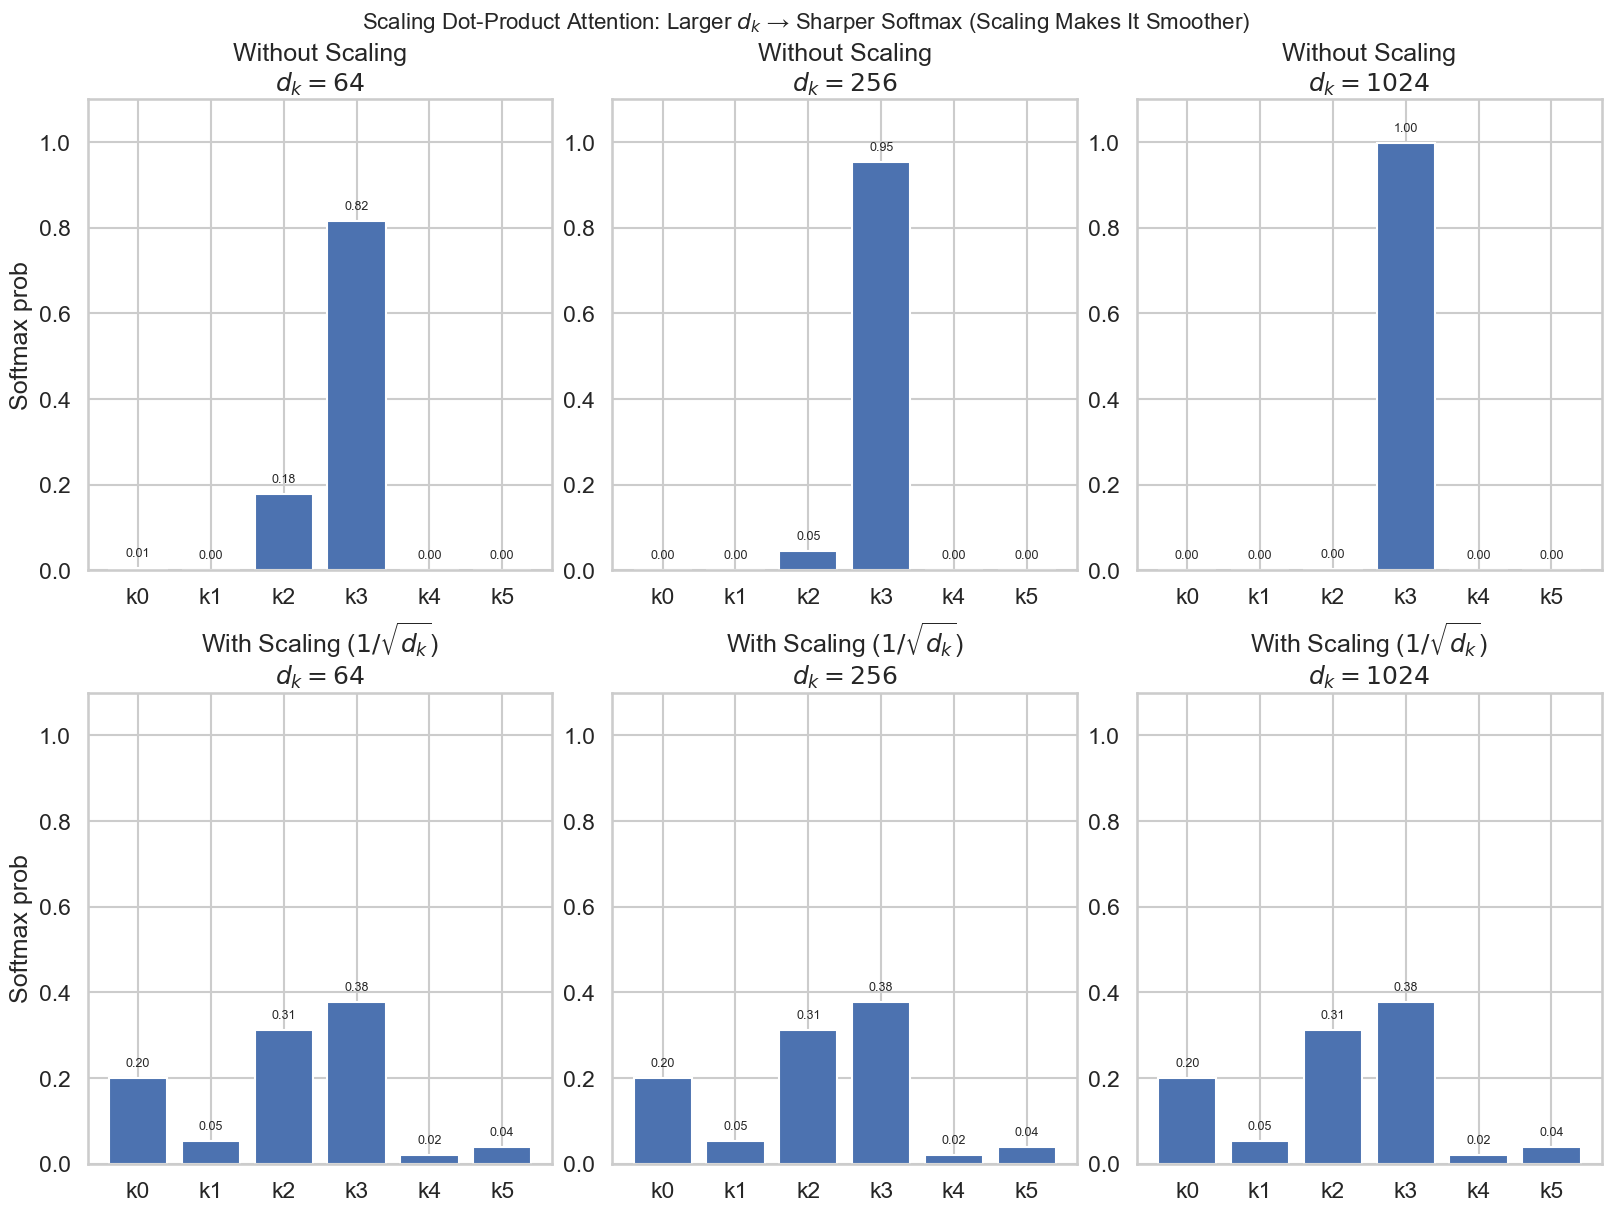

In [7]:
import numpy as np
import matplotlib.pyplot as plt


def softmax(z):
    z = z - np.max(z)  # stability
    ez = np.exp(z)
    return ez / ez.sum()


def demo_logits(dk, n=6, seed=42):
    """
    Dot-product-like logits with Var ~ d_k (since q·k ~ N(0, d_k) under simple assumptions).
    """
    rng = np.random.default_rng(seed)
    return rng.normal(loc=0.0, scale=np.sqrt(dk), size=n)


# --- settings ---
dks = [64, 256, 1024]
n = 6
labels = [f"k{i}" for i in range(n)]

# --- plot: 2 rows (no scaling vs scaling) x 3 cols (d_k) ---
fig, axes = plt.subplots(2, len(dks), figsize=(16, 12), constrained_layout=True)

for col, dk in enumerate(dks):
    logits = demo_logits(dk, n=n, seed=42)  # logits ~ N(0, sqrt(dk))
    p_no = softmax(logits)  # without scaling
    p_yes = softmax(logits / np.sqrt(dk))  # with 1/sqrt(dk)

    # Row 0: without scaling
    ax = axes[0, col]
    ax.bar(labels, p_no)
    ax.set_title(f"Without Scaling\n$d_k={dk}$")
    ax.set_ylim(0, 1.1)
    ax.set_ylabel("Softmax prob" if col == 0 else "")
    for i, v in enumerate(p_no):
        ax.text(i, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=9)

    # Row 1: with scaling
    ax = axes[1, col]
    ax.bar(labels, p_yes)
    ax.set_title(rf"With Scaling ($1/\sqrt{{d_k}}$)" + f"\n$d_k={dk}$")
    ax.set_ylim(0, 1.1)
    ax.set_ylabel("Softmax prob" if col == 0 else "")
    for i, v in enumerate(p_yes):
        ax.text(i, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=9)

fig.suptitle(
    "Scaling Dot-Product Attention: Larger $d_k$ → Sharper Softmax (Scaling Makes It Smoother)", fontsize=16
)
plt.show()
